<a href="https://colab.research.google.com/github/wsh32/machine_learning/blob/main/modules/05/Assignment_Notebook_05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Applications of Logistic Regression and Tooling Up

## Expected Time
We expect this to take 4-5 hours.

## Learning Objectives and Motivation

This course has three main strands.

1. Building mathematical and algorithmic foundation
2. Engineering processes for successful application of machine learning
3. Context and ethics of machine learning

Up until this point we've been doing a fair amount of (1) and (3), but we haven't had a chance to do much of (2).  At least, the things we've done in terms of machine learning applications have mostly been oriented towards demonstrating various properties of the algorithms we've been learning.

Today in class you'll have a chance to apply the algorithms that you are learning about to real problems.  In this process you'll start to get a sense of some of the issues that are involved in solving a problem using machine learning.

There will be two options for going through these exercises.

* *Option 1:* Guided work. You'll work through this notebook, which will guide you through the process. This is a good option if you feel like you need some scaffolding and are still wrapping your head around some of the concepts. We'll be using the pet adoption dataset, because Carrie wants to adopt a dog.

* *Option 2:* Try it from scratch! Start with the section "Choose a dataset for classification" below, and follow the Outline (exploring the data, choosing a feature representation, etc.). But work in a separate  notebook, where you build the elements of the model using what you've learned from previous assignments. This is a good option if you are fairly confident in the material so far, and want to stretch your brain.

Each of these options has different advantages, and you can switch between Option 1 and 2 depending on your learning needs. 

## Outline of the Activity

Today's work will consist of the following activities.
* Explore the data
* Practice train/test split
* Train a logistic regression model on the dataset
* Interpret weights learned by the model
* Evaluate the dataset performance
* Tweak the model in some way and evaluate the effect on performance
* Rinse and repeat

### Learning Goals
* Get a better handle on the machine learning train, interpret, validate, test cycle in machine learning
* Learn how to use tools like pandas and scikit learn for machine learning

### Deliverables

We will ask you if you fully engaged with the material, like we would for a regular assignment. However, due to the flexible nature of the assignment, this will be a single question. See Canvas for details.

In [ ]:
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

## Choose a Dataset (If you're going with Option 1, just read about the Pet Adoption dataset)

The focus of this activity will be on using logistic regression for classification.  Thus, you should choose a dataset that can naturally be approached as a ***classification problem***.  We are also going to be asking you to do a fair amount of interpretation of the fitted model, so you should try to choose a problem with ***a manageable number of independent variables*** (one exception would be computer vision tasks where if we use pixels as the input, we could visualize the weights as an image as we did in the in-class notebook from last class).

Here are some suggestions for datasets to use.  We have prepared some of these datasets for you by extracting the data into a reasonable format for learning.  Since you have limited time, you might want to choose one of these.  If you want to practice data wrangling on your own, you can pick one of the other datasets (or a dataset of your own choosing).

### Smile Detection

This is one of our favorite datasets to work with.  If you've taken QEA, you may have already had a chance to play around with it, but there's definitely a lot to explore.

You can play around with choosing different sorts of features (e.g., filtering or normalizing the image in different ways) and run some rigorous experiments to establish expected performance.

This dataset is called the [Genki dataset](https://inc.ucsd.edu/mplab/398.php) and it was collected at UC San Diego's Machine Perception Laboratory. The current links to the dataset appear to be defunct and unfortunately documentation is quite limited.  Paul's (Prof. Paul Ruvolo, who co-created this course with Sam in 2019) memory is that these images were collected by scraping public social media profiles.

In [ ]:
import gdown

gdown.download('https://drive.google.com/uc?id=1Wprh3vJY1_VsGpbXVJWEElQjVeHS2ovQ', 'train_human_genki.mat', False)

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.io import loadmat

data = loadmat('train_human_genki.mat')
images = data['images']
expression = data['expressions']

fig, ax = plt.subplots(10, 10, figsize=(20, 20))

for i in range(100):
    ax = plt.subplot(10, 10, i+1)
    plt.set_cmap('gray')
    ax.imshow(images[:, :, i].squeeze(), interpolation='none')
    ax.set_axis_off()
plt.show()

# expressions contains the expressions of each face (1 for smiling, 0 for not smiling)

### Aerial Cactus Identification

https://www.kaggle.com/c/aerial-cactus-identification/data
>
> To assess the impact of climate change on Earth's flora and fauna, it is vital to quantify how human activities such as logging, mining, and agriculture are impacting our protected natural areas. Researchers in Mexico have created the VIGIA project, which aims to build a system for autonomous surveillance of protected areas. A first step in such an effort is the ability to recognize the vegetation inside the protected areas. In this competition, you are tasked with creation of an algorithm that can identify a specific type of cactus in aerial imagery.



If you'd like to use these for inspiration: [Sample Aerial Cactus Identification Notebooks](https://www.kaggle.com/c/aerial-cactus-identification/notebooks) (these all seemed to use neural networks, but maybe you can find some that explore the data or use other techniques)

In [1]:
import gdown

gdown.download('https://drive.google.com/uc?authuser=0&id=10fBywwtsu5aTIlCSPuqzuXH7ICmJJ1RT&export=download', 'cactus_train_images.zip', False)
gdown.download('https://drive.google.com/uc?authuser=0&id=16IP3tlP7z30zYo6Lfn2dgEGVHRLjWxrW&export=download', 'cactus_train.csv', False)
!unzip -o cactus_train_images.zip > /dev/null

Downloading...
From: https://drive.google.com/uc?authuser=0&id=10fBywwtsu5aTIlCSPuqzuXH7ICmJJ1RT&export=download
To: /content/cactus_train_images.zip
20.1MB [00:00, 101MB/s] 
Downloading...
From: https://drive.google.com/uc?authuser=0&id=16IP3tlP7z30zYo6Lfn2dgEGVHRLjWxrW&export=download
To: /content/cactus_train.csv
100%|██████████| 683k/683k [00:00<00:00, 65.0MB/s]


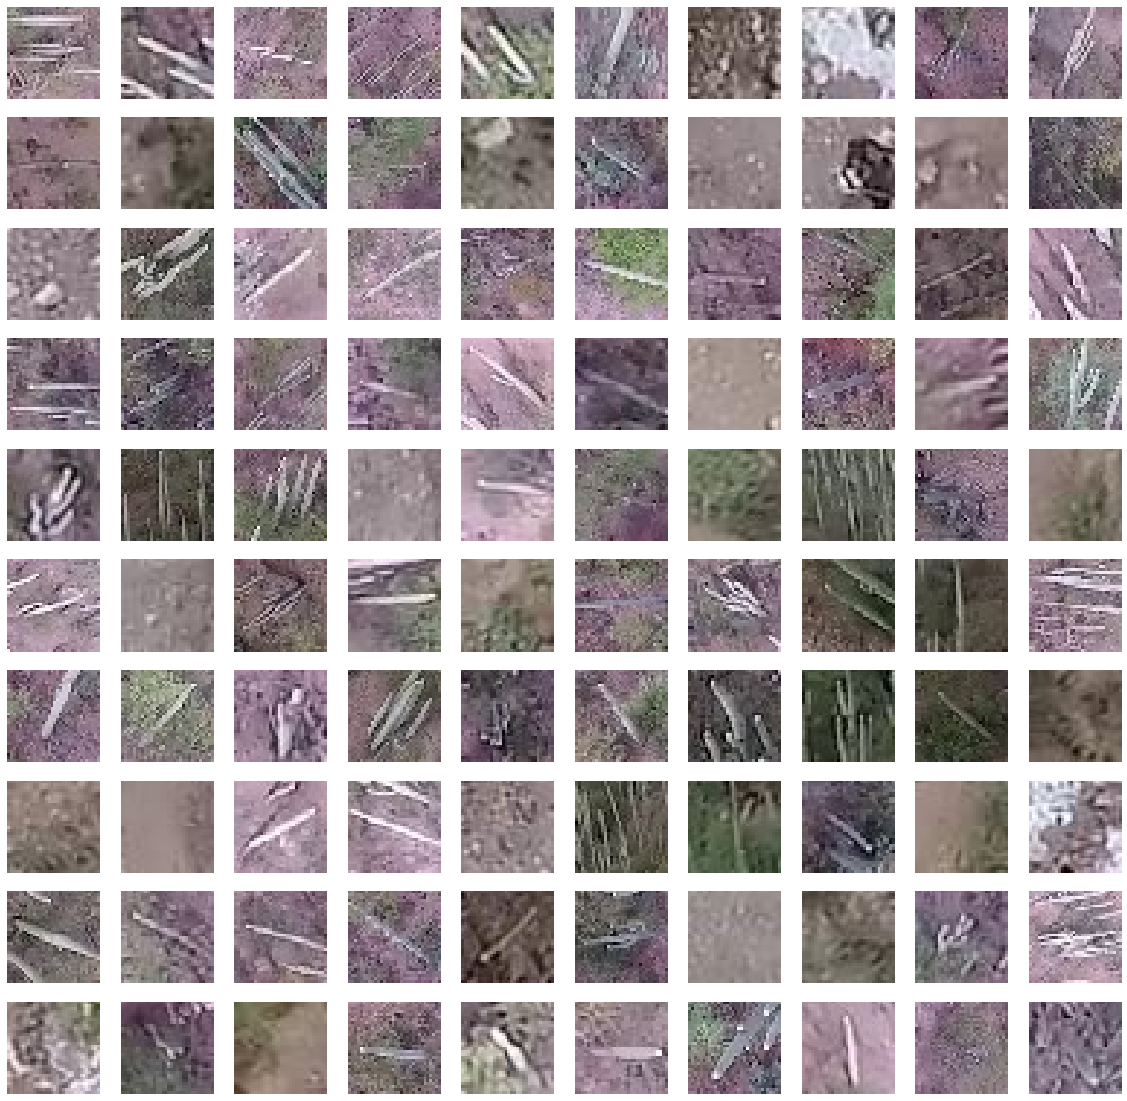

In [33]:
import cv2
import numpy as np
from glob import glob
import pandas as pd
from os import path
%matplotlib inline
import matplotlib.pyplot as plt

df = pd.read_csv('cactus_train.csv')
df.index = df['id']
images = []
has_cactus = []
for file in sorted(glob('train/*.jpg')):
    im = cv2.imread(file)
    # opencv reads in the image in BGR color channel order.  Switch to RGB
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    d, filename = path.split(file)
    has_cactus.append(df.loc[filename, 'has_cactus'])
    images.append(im)

images = np.array(images)
y = np.array(has_cactus)

fig, ax = plt.subplots(10, 10, figsize=(20, 20))

for i in range(100):
    ax = plt.subplot(10, 10, i+1)
    ax.imshow(images[i].squeeze(), interpolation='none')
    ax.set_axis_off()
plt.show()

In [50]:
# Clean up data
from sklearn.model_selection import train_test_split

images_flat = [np.reshape(image, -1) for image in images]

X_train, X_test, y_train, y_test = train_test_split(images_flat, y, test_size=0.5)

In [51]:
from sklearn.linear_model import LogisticRegression

# Train logistic regression model
clf = LogisticRegression(max_iter=10000, C=0.0001)
clf = clf.fit(X_train, y_train)

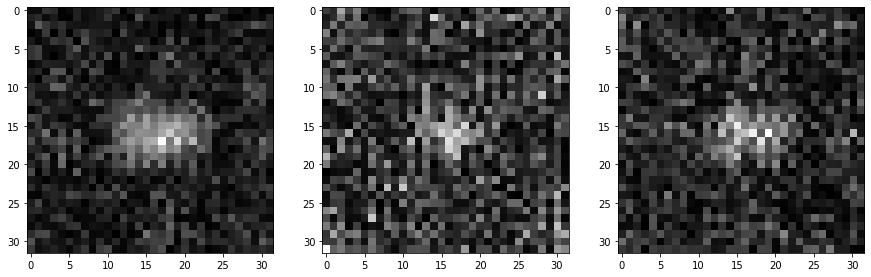

In [104]:
# Visualize model weights
w = clf.coef_
w_image = np.reshape(w, images[0].shape)

fig, ax = plt.subplots(1, w_image.shape[-1], figsize=(15, 15))

for i in range(w_image.shape[-1]):
  ax = plt.subplot(1, w_image.shape[-1], i+1)
  ax.imshow(np.absolute(w_image[:, :, i]), cmap="gray")


In [52]:
# Test model
y_train_predict = clf.predict(X_train)
train_score = sum(y_train_predict == y_train) / len(y_train)

y_test_predict = clf.predict(X_test)
test_score = sum(y_test_predict == y_test) / len(y_test)

print(f"Train accuracy: {train_score * 100}%")
print(f"Test accuracy: {test_score * 100}%")

# Look at score splits with plant vs no plant
no_plants_test_score = sum((y_test_predict == y_test)[np.where(y_test == 0)]) / sum(y_test == 0)

print(f"No plants accuracy: {no_plants_test_score * 100}%")

Train accuracy: 94.51428571428572%
Test accuracy: 88.89142857142858%
No plants accuracy: 83.13796212804328%


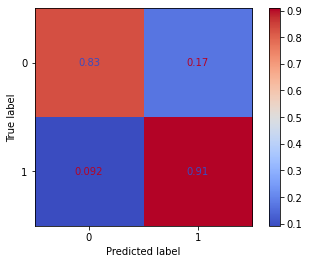

In [62]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(clf, X_test, y_test, cmap="coolwarm", normalize="true")

### MNIST

This is probably the most famous dataset in all of machine learning.  The task is to classify handwritten digits.  Read all about [MNIST on Wikipedia](https://en.wikipedia.org/wiki/MNIST_database).

If you'd like to use these for inspiration: [Sample MNIST Notebooks on Kaggle](https://www.kaggle.com/c/digit-recognizer/notebooks) (warning: a lot of these seem to use neural networks, which we will be learning soon)

In [ ]:
from sklearn.datasets import fetch_openml

# Load data from https://www.openml.org/d/554
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots(10, 10, figsize=(20, 20))

for i in range(100):
    ax = plt.subplot(10, 10, i+1)
    plt.set_cmap('gray')
    ax.imshow(X[i,:].reshape((28, 28)), interpolation='none')
    ax.set_axis_off()
plt.show()

### Pet Adoption Speed Prediction

This dataset is taken from a Kaggle competition called [How Cute is that Doggy in the Shelter](https://www.kaggle.com/c/petfinder-adoption-prediction/overview).

The full competition uses images, text, and various attributes of the pet to predict adoption speed.  For our sample code, we'll just focus on the attributes (and leave the text and images alone).

If you'd like to use these for inspiration: [Sample Kaggle Notebooks from Petfinder competition](https://www.kaggle.com/c/petfinder-adoption-prediction/notebooks).

In [ ]:
#Import data into the notebook.
import gdown

gdown.download('https://drive.google.com/uc?authuser=0&id=1ckBa2ULUhF8qvlXwX3qWMs2TJNNdPHbq&export=download', 'pet_finder_train.csv', False)
gdown.download('https://drive.google.com/uc?authuser=0&id=1A_0y9OQhLB6GrI6FW3PXXtiyGdwtXF6z&export=download', 'breed_labels.csv', False)
gdown.download('https://drive.google.com/uc?authuser=0&id=1hRb7pOd86eYTYg1D_4WF7hSkHVPeFKfJ&export=download', 'color_labels.csv', False)

In [ ]:
#Take a look at the dataset.
import pandas as pd

df = pd.read_csv('pet_finder_train.csv')
df_breeds = pd.read_csv('breed_labels.csv')
df_colors = pd.read_csv('color_labels.csv')
df

## Start here if you're doing Option 1.
Option 2-ers-- pick their dataset and start coding in a seperate (new) notebook.

You'll notice that we are reading in this data with Pandas.  Pandas is useful to know (and it will be even more useful next module).  Here we can work with a fairly minimal set of tools.  Consider reading [10 minutes to Pandas](https://pandas.pydata.org/pandas-docs/stable/user_guide/10min.html) for some of the basic operations.  If you don't want to deal with Pandas, we suggest extracting columns from the data frame using:

> `df['column_name']`

For example, in order to make a numpy array with deworming status and age you could use the following code.

Read the [documentation](https://www.kaggle.com/c/petfinder-adoption-prediction/data) to understand how to interpret the values.

In [ ]:
import numpy as np

X = np.vstack((df['Age'], df['Dewormed'])).T
y = np.asarray(df['AdoptionSpeed'])
print("X.shape", X.shape)
print("y.shape", y.shape)

## Exploring the Data

One of the first things you should do when you apply a machine learning approach to a new dataset is to explore the dataset.  There are way too many folks that just take the data, train a model, and look at the percent accuracy.  This approach entirely misses the point.
* You cannot properly interpret your results unless you know what sort of data you are working with.
* You will not make good modeling decisions if you aren't familiar with the data.
* You will not be able to iterate your model effectively if you aren't familiar with the data.

### Suggested Steps to Perform
(we trust you to deviate from these steps if you have good reasons.)

For this part of the assignment, we suggest you perform some subset of the following things (note that for images a lot of these things can be naturally visualized as images, but for the tabular data you will probably wind up making plots, e.g., bar charts).
* For numerical data, look at the means and standard deviations of all of your features
* For numerical data, look at the means and standard deviations of all of your features separated out according to the output value (e.g., look at the mean of each feature when the output is 1 and separately look at the mean of each feature when the output is 0).
* For numerical data, look at pairwise correlations
* Make histograms or density plots for numerical data
* For non-numerical data (e.g., text), consider making bar charts to show frequency of occurrence of different values.

### Resources
* [Infographic Cheat Sheet Data Exploration-python](https://www.analyticsvidhya.com/blog/2015/06/infographic-cheat-sheet-data-exploration-python/)
* [A Guide to Pandas and Matplotlib for Data Exploration](https://towardsdatascience.com/a-guide-to-pandas-and-matplotlib-for-data-exploration-56fad95f951c)
* [Pandas Cheatsheet](https://pandas.pydata.org/Pandas_Cheat_Sheet.pdf)
* [Python Graph Gallery](https://www.python-graph-gallery.com/)

In [ ]:
# your solution goes here

## Possible solutions

In [ ]:
# a possible solution
# (you should make several of these)
plt.plot(df['Age'], df['AdoptionSpeed'], linestyle='none', marker='o', alpha=0.1)
plt.show()

# a fancy solution, may take a minute to run.
# more at: https://www.python-graph-gallery.com/111-custom-correlogram
import seaborn as sns
import matplotlib.pyplot as plt
sns.pairplot(df, y_vars=["Age","MaturitySize","Dewormed","PhotoAmt","Breed1"],x_vars=["AdoptionSpeed"])
# You'll note here there is a lot of overplotting! It makes things hard to interpret.

#Another fancy plot option
sns.jointplot(x=df["Age"], y=df["AdoptionSpeed"], kind='kde')
sns.jointplot(x=df["MaturitySize"], y=df["AdoptionSpeed"], kind='kde')
sns.jointplot(x=df["Dewormed"], y=df["AdoptionSpeed"], kind='kde')



In [ ]:
# This is a nice way to look at the mean & std of the data.
df.describe()
# what's going on with Age?? If you're confused, check out the description from that category.

## Choosing Your Features

Once you've gotten a feel for the dataset, you will need to choose an initial set of features to use for training your model.  We suggest that for your first iteration you choose a pretty simple feature set that will be easy to interpret and iterate upon.

Here are some additional suggestions for creating features.
* If you have data that is categorical (that can take on a discrete set of values and those values are not naturally ordered in anyway), consider using the `pandas.get_dummies` function to encode.
* If you have images, consider using pixels as your feature set.  You may experiment with using [principal components analysis](https://en.wikipedia.org/wiki/Principal_component_analysis) to reduce the dimensionality of your data before applying logistic regression.
* If you have images, consider filtering them in various ways.  You could then concatenate the pixels from the filtered image with the original pixels (or replace them).  [OpenCV has some good methods](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_table_of_contents_imgproc/py_table_of_contents_imgproc.html) for doing this.

### Resources
* [pandas.get_dummmies documentation](https://pandas.pydata.org/pandas-docs/version/0.21/generated/pandas.get_dummies.html)
* [Pandas Cheatsheet](https://pandas.pydata.org/Pandas_Cheat_Sheet.pdf)
* [Guide to Encoding Categorical Variables in Python](https://pbpython.com/categorical-encoding.html) (really long, not suitable for skimming)
* [Principle Components Analysis with sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)
* [OpenCV Image Filtering](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_table_of_contents_imgproc/py_table_of_contents_imgproc.html)

## A possible solution

In [ ]:
# Carrie likes all the features in this dataset, but the text ones will
# be difficult for the logsitic regression I'd like to try.

#Drop text columns
X=df.drop(columns=['Description','Name','RescuerID','PetID'])
X

## Train-test split

If we don't do this, we won't know how if our model worked! Recall the train_test_split function from the sklearn library from a previous assignment, and implement it here. (I'd reccomend finding an example of a train-test split to help with this, and there's always the solution if you get really stuck.)


In [ ]:
# Your answer here

## Possible Solution

In [ ]:
# Solution
# For this, we'll have to seperate out our data into features (X) and results (y)
y=df["AdoptionSpeed"] # only AdoptionSpeed
X=df.drop(columns=['Description','Name','RescuerID','PetID','AdoptionSpeed'])
# what happens if you don't drop 'AdoptionSpeed'?

# Try printing a result to make sure it worked the way we thought
X

# Now we can train test split.
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

## Training and Evaluating a Model

We recommend you use scikit learn for training your model.  You can use the built-in [Logistic Regression model](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html).  If you want to play around with logistic regression with a ridge term (exactly the same ideas as we saw in linear regression), you can use [LogisticRegressionCV](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html).

This is similar to a previous exercise, where we used sklearn on iris data. If your memory is fuzzy, go back and look that up.

You may find [sklearn's Accuracy Score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html) helpful.

In [ ]:
#train and evaulate your model here! You can evaluate by plotting.

## A possible solution

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# If you use the LogisticRegression without a high
# value for max_iter, you'll get an error. These two 
# paremeters are identical to that in the face pose
# notebook- feel free to always look up/reference previous 
# code.
clf=LogisticRegression(max_iter=10000,C=0.0000001).fit(X_train, y_train)
clf = clf.fit(X_train, y_train)
y_pred=clf.predict(X_test)

#One metric!
acc=accuracy_score(y_test, y_pred)
acc

## Interpreting the Model Weights

When you train your model with sklearn, the model weights will be stored in the attribute `.coef_`.  The bias term will be stored in `.intercept_`.

If you are working with images (a group who did Option 1 and is reading this for hints), consider visualizing the weights as images (like we did with the head pose dataset).

In [ ]:
#Investigate your model here

## A possible solution

In [ ]:
pd.DataFrame(clf.coef_[0], X.columns, columns=['coef']).sort_values(by='coef', ascending=False)
# Does this make sense? What are the strongest and weakest coefficents? 

## Interpreting results
A useful tool is a confusion matrix (fun name, right?). Take some time to read the [Wikipedia Entry](https://en.wikipedia.org/wiki/Confusion_matrix) so you understand what this is. 

Let's say you were training a model to figure out if something was an asteroid or not an asteroid in an image. A true positive would be a real asteroid that your model identified as a real asteroid. A false positive would be a not-asteroid that your model identified as an asteroid. A true negative is a not-asteroid that your model identified as a not-asteroid. And (you can see where this is going) a false negative is an actual asteroid that your model identified as a not-asteroid. 

Let's take a look at a confusion matrix for our problem.

In [ ]:
from sklearn.metrics import plot_confusion_matrix
class_names=list(X_test.columns) # Gets names of each column.
plot_confusion_matrix(clf, X_test, y_test, display_labels=class_names,cmap=plt.cm.Blues)

Take a second to check your understanding. What catagory is most often true positives? What category is often incorrectly classified?

## Tweaking the Model

Based on your results, come up with a tweak to your model.  You should have some intention behind the tweak.  The most natural one might be to improve your score on some metric (probably accuracy).  Alternatively, you might want to remove some undesireable property of your previous model (e.g., it might be exploiting a dubious strategy to solve the problem based on a spurious correlation in the data).

## A possible solution


Right now, this isn't a great model. I wonder if my code would be stronger if it had fewer features. I might remove the cat data and just focus on dogs, or visa versa. I might also eliminate groups of animals from the data and try again, because it seems like the qualities of multiple-animal adoptions muddle the data.

## Iterate

Based on your tweaked model, rerun your experiment.  Discuss how the results changed and what you learned from it.